# Administrative Stuff

In [272]:
# Set up GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [273]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [274]:
# Import data related libraries
import pandas as pd
import numpy as np
import random
import json
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt

# Import encoders and scalers
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# Import train test split and metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score

# Import neural network libraries
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D


In [275]:
# Importing motion model
from keras.models import load_model

model_path = 'drive/MyDrive/3237/firstModel_stackedLSTM.hd5'
motion_model = load_model(model_path)

# Load and clean data

In [276]:
# Replace double quotes with single quotes for moods JSON arrays
f = open('drive/MyDrive/3237/song_data.csv','r+')
text = f.read()
text = text.replace('"["', '"[?').replace('", "', '?,?').replace('"]"', '?]"') # Changed to "[$Happy$,$Sad$]" for easy replacing later
f.seek(0)
f.write(text)
f.close()

In [277]:
# Importing data
df = pd.read_csv('drive/MyDrive/3237/song_data.csv', index_col=0)

df.drop('uuid', axis=1, inplace=True) # drops uuid column
df.dropna(inplace=True) # drop rows with nan values

# Format contents of columns properly
for col in df.columns:
  if col not in ['id','isSkipped']:
    if col == 'moods':
      df[col] = df[col].apply(lambda x:str(x).replace('?','"'))
    df[col] = df[col].apply(lambda x:json.loads(x))

df['activity'] = df.apply(lambda _: '', axis=1) # add empty activity column
df.head()

,gyroX,gyroY,gyroZ,accelX,accelY,accelZ,optical,temp,humidity,moods,isSkipped,activity
id,,,,,,,,,,,,
1,"[499.30572509765625, 499.53460693359375, 0.198...","[1.861572265625, 2.49481201171875, 1.022338867...","[1.24359130859375, 1.2359619140625, 1.06048583...","[1.1943359375, 1.201171875, 1.1845703125, 1.18...","[1.1455078125, 1.1591796875, 1.1630859375, 1.1...","[3.68359375, 3.654296875, 3.6748046875, 3.6650...","[139.64, 138.36, 139.64, 140.28]","[30.50567626953125, 30.50567626953125, 30.5056...","[71.3134765625, 71.3134765625, 71.3134765625]","[Depressive, Atmospheric]",0.0,
2,"[498.1765747070313, 0.98419189453125, 1.579284...","[32.27996826171875, 14.7247314453125, 9.864807...","[497.9248046875, 496.368408203125, 494.9645996...","[2.9326171875, 2.9345703125, 2.728515625, 2.64...","[0.8466796875, 0.74609375, 0.865234375, 15.524...","[2.7548828125, 2.8037109375, 2.806640625, 3.34...","[123.24, 123.24, 139.32, 228.64]","[31.69403076171875, 31.69403076171875, 31.6940...","[67.05322265625, 67.05322265625, 67.0532226562...",[Depressive],0.0,
3,"[15.76995849609375, 10.65826416015625, 6.87408...","[488.36517333984375, 486.5798950195313, 496.92...","[3.86810302734375, 5.0811767578125, 498.947143...","[14.0107421875, 14.3212890625, 14.232421875, 1...","[14.96484375, 15.212890625, 15.275390625, 15.1...","[3.2021484375, 3.3291015625, 3.375, 3.35644531...","[256.08, 307.84000000000003, 315.2, 301.36, 30...","[32.21771240234375, 32.21771240234375, 32.2177...","[65.850830078125, 65.850830078125, 65.85083007...","[Passionate, Depressive]",0.0,
4,"[499.93896484375, 499.45068359375, 499.7482299...","[1.82342529296875, 2.74658203125, 1.8844604492...","[1.57928466796875, 1.434326171875, 1.365661621...","[1.7353515625, 1.708984375, 1.7333984375, 1.71...","[13.7841796875, 13.80078125, 13.7744140625, 13...","[2.8232421875, 2.8369140625, 2.8154296875, 2.8...","[127.08, 126.76, 125.48, 124.52]","[32.42919921875, 32.42919921875, 32.4291992187...","[64.6728515625, 64.6728515625, 64.6728515625, ...",[Elegant],1.0,
5,"[499.9465942382813, 0.03814697265625, 499.7482...","[2.01416015625, 1.77001953125, 1.7852783203125...","[1.1444091796875, 1.2359619140625, 1.129150390...","[0.4580078125, 0.4609375, 0.453125, 0.43847656...","[13.181640625, 13.1689453125, 13.1787109375, 1...","[2.6806640625, 2.693359375, 2.6875, 2.68652343...","[145.76, 144.48, 146.4, 144.8]","[32.42919921875, 32.42919921875, 32.4291992187...","[64.6728515625, 64.6728515625, 64.6728515625, ...","[Passionate, Depressive]",1.0,


In [278]:
# Remove defective data
defective_ids = []
for id,row in df.iterrows():
    # defective if temp array only has -40 values
    # defective if any humidity values are above 99.99

    if len([k for k in row['temp'] if k == -40]) == len(row['temp']) or \
       len([k for k in row['humidity'] if k > 99.99]) == len(row['humidity']) or \
       len([k for k in row['optical'] if k > 1000]) == len(row['optical']):
        defective_ids.append(id)
    
    # if only some values are defective, keep the row, but remove defective values
    # remove -40 temp values and >99.99 humidity values
    elif (-40 in row['temp']) or len([k for k in row['humidity'] if k>99.99]):
        row['temp'] = [k for k in row['temp'] if k!=-40]
        row['humidity'] = [k for k in row['humidity'] if k < 99.99]

    # some gyro/accel data have 40 samples
    # take the last 30 samples for these rows
    for col in df.columns[:6]:
        if len(row[col]) > 30:
            df.at[id,col] = row[col][-30:]
filtered_df = df[~df.index.isin(defective_ids)].copy() # .copy() to avoid warning
print('Defective row ids are: ',defective_ids)

Defective row ids are:  ['21', '22', '33', '148', '149', '150', '151', '152', '154', '157', '158', '171', '172', '174', '177', '178', '180', '181', '182', '183', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '236', '238', '245', '246', '247', '248', '249', '250', '251', '252', '341', '347', '348', '349', '350', '353', '357', '358', '359', '360', '361', '362', '363', '364', '365', '366', '367', '368', '369', '370', '371', '372', '373', '374', '375', '376', '377', '378', '379', '380', '381', '382', '383', '384', '385', '386', '387', '388', '389', '390', '391', '392', '393', '394']


In [279]:
# Using motion model to predict activity column based on gyro and accel
x = [list(k) for k in filtered_df.iloc[:,:6].values]
x = np.array(x) # (num_samples, 6, 30)
x = np.array([k.T for k in x]) # reshape as (num_samples, 30, 6)

pred = motion_model.predict(x)

encoder_categories = np.array(['Running', 'Walking', 'Working']) # hardcoded categories from 'Physical Activity Classification.ipynb'
filtered_df['activity'] = encoder_categories[np.argmax(pred, axis=1)]
filtered_df = filtered_df.iloc[:,6:].copy() # drop gyro and accel columns

filtered_df.head()

,optical,temp,humidity,moods,isSkipped,activity
id,,,,,,
1,"[139.64, 138.36, 139.64, 140.28]","[30.50567626953125, 30.50567626953125, 30.5056...","[71.3134765625, 71.3134765625, 71.3134765625]","[Depressive, Atmospheric]",0.0,Working
2,"[123.24, 123.24, 139.32, 228.64]","[31.69403076171875, 31.69403076171875, 31.6940...","[67.05322265625, 67.05322265625, 67.0532226562...",[Depressive],0.0,Working
3,"[256.08, 307.84000000000003, 315.2, 301.36, 30...","[32.21771240234375, 32.21771240234375, 32.2177...","[65.850830078125, 65.850830078125, 65.85083007...","[Passionate, Depressive]",0.0,Working
4,"[127.08, 126.76, 125.48, 124.52]","[32.42919921875, 32.42919921875, 32.4291992187...","[64.6728515625, 64.6728515625, 64.6728515625, ...",[Elegant],1.0,Working
5,"[145.76, 144.48, 146.4, 144.8]","[32.42919921875, 32.42919921875, 32.4291992187...","[64.6728515625, 64.6728515625, 64.6728515625, ...","[Passionate, Depressive]",1.0,Working


In [280]:
# Obtain mean optical, temp and humidity values
for col in filtered_df.columns:
    if col not in ['moods','isSkipped','activity']:
        filtered_df[col] = filtered_df[col].apply(np.mean)
filtered_df.sample(5)

,optical,temp,humidity,moods,isSkipped,activity
id,,,,,,
85,87.560,34.131165,75.103760,[Passionate],0.0,Working
47,66.450,31.497650,79.272461,[Athletic],1.0,Working
414,19.275,32.419128,71.752930,"[Atmospheric, Athletic]",0.0,Working
310,205.380,32.625580,80.603027,[Athletic],1.0,Working
301,0.460,30.968933,35.168457,[Athletic],1.0,Working


In [281]:
# One-hot encoding for activity
activities = []
for k in filtered_df['activity']:
    activities.append(k)
activities = np.unique(np.array(activities))
for activity in activities:
    activity_values = filtered_df['activity'].astype(str).str.contains(activity)
    activity_values = activity_values.astype(int)
    filtered_df[activity] = activity_values
filtered_df.drop('activity', axis=1, inplace=True)

filtered_df.head()

,optical,temp,humidity,moods,isSkipped,Running,Walking,Working
id,,,,,,,,
1,139.480,30.505676,71.313477,"[Depressive, Atmospheric]",0.0,0,0,1
2,153.610,31.694031,67.053223,[Depressive],0.0,0,0,1
3,297.792,32.217712,65.850830,"[Passionate, Depressive]",0.0,0,0,1
4,125.960,32.429199,64.672852,[Elegant],1.0,0,0,1
5,145.360,32.429199,64.672852,"[Passionate, Depressive]",1.0,0,0,1


In [282]:
# One-hot encoding for moods
moods = []
for k in filtered_df['moods'].values:
    moods += list(k)
moods = np.unique(np.array(moods))
for mood in moods:
    mood_values = filtered_df['moods'].astype(str).str.contains(mood)
    filtered_df[mood] = mood_values
filtered_df.drop('moods', axis=1, inplace=True)
print('Added one-hot encoded columns for moods:')
filtered_df.head()

Added one-hot encoded columns for moods:


,optical,temp,humidity,isSkipped,Running,Walking,Working,Aggressive,Athletic,Atmospheric,Celebratory,Depressive,Elegant,Passionate,Warm
id,,,,,,,,,,,,,,,
1,139.480,30.505676,71.313477,0.0,0,0,1,False,False,True,False,True,False,False,False
2,153.610,31.694031,67.053223,0.0,0,0,1,False,False,False,False,True,False,False,False
3,297.792,32.217712,65.850830,0.0,0,0,1,False,False,False,False,True,False,True,False
4,125.960,32.429199,64.672852,1.0,0,0,1,False,False,False,False,False,True,False,False
5,145.360,32.429199,64.672852,1.0,0,0,1,False,False,False,False,True,False,True,False


In [283]:
# Invert mood boolean values based on "isSkipped"
for mood in moods:
    filtered_df[mood] = np.abs(filtered_df[mood] - filtered_df['isSkipped'])
filtered_df.drop('isSkipped', axis=1, inplace=True)
print('Invert mood values based on "isSkipped" boolean:')
filtered_df.head()

Invert mood values based on "isSkipped" boolean:


,optical,temp,humidity,Running,Walking,Working,Aggressive,Athletic,Atmospheric,Celebratory,Depressive,Elegant,Passionate,Warm
id,,,,,,,,,,,,,,
1,139.480,30.505676,71.313477,0,0,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,153.610,31.694031,67.053223,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,297.792,32.217712,65.850830,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,125.960,32.429199,64.672852,0,0,1,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
5,145.360,32.429199,64.672852,0,0,1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0


# Outliers
When initially plotting the graphs for optical column, we observed that there were a few extreme values (about 60K +) that were skewing the dataset. This would affect the optical values after normalizing especially. So I removed those rows with the defective values.

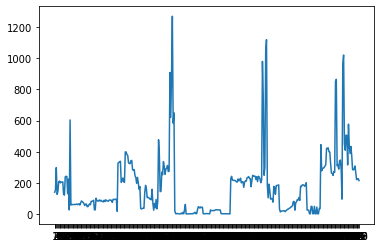

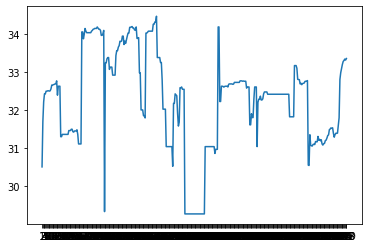

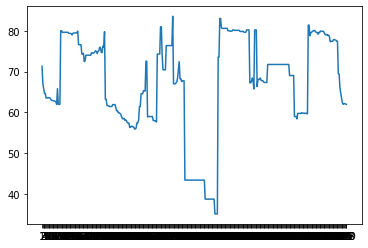

In [284]:
# Looking at data distribution in optical, temp, humidity
optical = filtered_df['optical']
plt.plot(optical)
plt.show()

temp = filtered_df['temp']
plt.plot(temp)
plt.show()

humidity = filtered_df['humidity']
plt.plot(humidity)
plt.show()

# Data imbalance
One big issue with multi label classification using neural networks is data imablance. Data imbalance occurs when some labels in the dataset occur more frequently than others. This causes the neural netowkr to only learn how to predict the frequent classes.

From the graph below, we can tell that our dataset is rather balanced for song moods (this is because we used a radom selection of songs when collecting data).

However, our data is not balanced for activities as we have a lot more "Working" data than "Walking" or "Running". We will be dealing with this using oversampling (randomly duplicating entries from the minority class). We chose to do oversampling instead of undersampling because we have a small dataset of only 300+ rows.

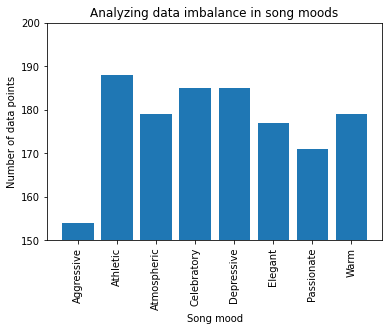

In [285]:
# Analyzing whether there is data imbalance in music categories
aggressive = filtered_df['Aggressive'].sum()
athletic = filtered_df['Athletic'].sum()
atmospheric	= filtered_df['Atmospheric'].sum()
celebratory	= filtered_df['Celebratory'].sum()
depressive = filtered_df['Depressive'].sum()
elegant	= filtered_df['Elegant'].sum()
passionate = filtered_df['Passionate'].sum()
warm = filtered_df['Warm'].sum()

mood_bars = [aggressive, athletic, atmospheric, celebratory, depressive, elegant, passionate, warm]

x = np.arange(8)
plt.bar(x,height=mood_bars)
plt.ylim([150, 200])
plt.xticks(x, ['Aggressive', 'Athletic', 'Atmospheric', 'Celebratory', \
                 'Depressive', 'Elegant', 'Passionate', 'Warm'], rotation=90)
plt.xlabel('Song mood')
plt.ylabel('Number of data points')
plt.title('Analyzing data imbalance in song moods')
plt.show()

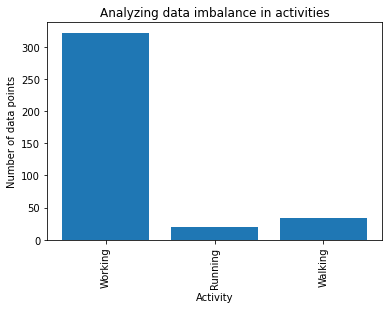

In [286]:
# Analyzing whether there is data imbalance in activities
working = filtered_df['Working'].sum()
running = filtered_df['Running'].sum()
walking	= filtered_df['Walking'].sum()

activity_bars = [working, running, walking]

x = np.arange(3)
plt.bar(x,height=activity_bars)
plt.xticks(x, ['Working', 'Running', 'Walking'], rotation=90)
plt.xlabel('Activity')
plt.ylabel('Number of data points')
plt.title('Analyzing data imbalance in activities')
plt.show()

# MLP Classifier
* Do multi-label classification
* Normalize input data before training, to control loss

In [287]:
# Split features from target
X = filtered_df[['optical', 'temp', 'humidity', 'Working', 'Running', 'Walking']]
Y_df = filtered_df[['Aggressive', 'Athletic', 'Atmospheric', 'Celebratory', \
                 'Depressive', 'Elegant', 'Passionate', 'Warm']]
X.head()

,optical,temp,humidity,Working,Running,Walking
id,,,,,,
1,139.480,30.505676,71.313477,1,0,0
2,153.610,31.694031,67.053223,1,0,0
3,297.792,32.217712,65.850830,1,0,0
4,125.960,32.429199,64.672852,1,0,0
5,145.360,32.429199,64.672852,1,0,0


In [288]:
# Normalize input data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

# apply transform
X = scaler.fit_transform(X)
Y = Y_df.to_numpy()
X_df = pd.DataFrame(X, columns=['optical', 'temp', 'humidity', 'Working', 'Running', 'Walking'])

print('Inputs to MLP')
X_df.sample(5)

Inputs to MLP


,optical,temp,humidity,Working,Running,Walking
315,0.000755,0.680851,0.508427,1.0,0.0,0.0
266,0.074903,0.564797,0.680467,1.0,0.0,0.0
141,0.216338,1.000000,0.464786,1.0,0.0,0.0
221,0.170326,0.646035,0.940924,1.0,0.0,0.0
226,0.176715,0.646035,0.938906,1.0,0.0,0.0


In [289]:
print('Target outputs of MLP')
Y_df.sample(5)

Target outputs of MLP


,Aggressive,Athletic,Atmospheric,Celebratory,Depressive,Elegant,Passionate,Warm
id,,,,,,,,
175,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
316,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
420,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
525,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
332,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [290]:
# MLP model definition
def get_model(n_inputs, n_outputs):
  model = Sequential()

  # Input layer
  model.add(Dense(32, input_dim=n_inputs, activation='relu'))

  # Hidden layer
  model.add(Dense(64, activation='relu'))

  # Output layer
  model.add(Dense(n_outputs, activation='sigmoid'))

  # Create a Stochastic Gradient Descent optimizer
  sgd  = SGD(learning_rate = 0.01, decay = 1e-4, momentum = 0.1)

  # Create adam optimizer
  adam = Adam(learning_rate=0.0001)

  # Compile the model.
  model.compile(loss='binary_crossentropy', optimizer=sgd,
              metrics='accuracy')
  return model

In [291]:
# Training and evaluating the model using k-fold cross validation
def evaluate_model_cv(X, Y):
  results = list()
  n_inputs, n_outputs = X.shape[1], Y.shape[1]

  # define evaluation procedure
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  
  # enumerate folds
  for train_ix, test_ix in cv.split(X):
    # prepare data
    X_train, X_test = X[train_ix], X[test_ix]
    Y_train, Y_test = Y[train_ix], Y[test_ix]
    
    # define model
    model = get_model(n_inputs, n_outputs)
    
    # fit model
    model.fit(x = X_train, y = Y_train, epochs = 50, verbose=0)
    
    # make a prediction on the test set
    yhat = model.predict(X_test)
    
    # round probabilities to class labels
    yhat = yhat.round()
    
    # calculate accuracy
    acc = accuracy_score(Y_test, yhat)
    
    # store result
    print(acc)
    results.append(acc)
  return results

# evaluate model
results = evaluate_model_cv(X, Y)

# summarize performance
print('Accuracy: %.3f (%.3f)' % (mean(results), std(results)))

0.02631578947368421
0.0
0.02631578947368421
0.0
0.0
0.02631578947368421
0.0
0.02702702702702703
0.02702702702702703
0.0
0.0
0.0
0.0
0.0
0.0
0.02631578947368421
0.05405405405405406
0.0
0.0
0.0
0.02631578947368421
0.02631578947368421
0.02631578947368421
0.02631578947368421
0.0
0.05263157894736842
0.0
0.0
0.0
0.0
Accuracy: 0.012 (0.016)


In [292]:
# Training and evaluating the model using train test split
def evaluate_model_normal(X, Y):
  n_inputs, n_outputs = X.shape[1], Y.shape[1]

  # Split train and test
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0, test_size = 0.2)
  
  # define model
  model = get_model(n_inputs, n_outputs)
    
  # fit model
  model.fit(x = X_train, y = Y_train, shuffle = True, batch_size = 60, 
          epochs = 150, validation_data = (X_test, Y_test))
    
  # make a prediction on the test set
  yhat = model.predict(X_test)
  
  # round probabilities to class labels
  yhat = yhat.round()
  
  # calculate accuracy
  acc = accuracy_score(Y_test, yhat)
  
  return acc

# evaluate model
acc = evaluate_model_normal(X, Y)

# summarize performance
print('Accuracy: %.3f' % acc)

Epoch 1/150
5/5 [==============================] - 1s 44ms/step - loss: 0.6964 - accuracy: 0.0933 - val_loss: 0.6962 - val_accuracy: 0.0395
Epoch 2/150
5/5 [==============================] - 0s 8ms/step - loss: 0.6963 - accuracy: 0.0933 - val_loss: 0.6962 - val_accuracy: 0.0395
Epoch 3/150
5/5 [==============================] - 0s 9ms/step - loss: 0.6962 - accuracy: 0.0933 - val_loss: 0.6961 - val_accuracy: 0.0395
Epoch 4/150
5/5 [==============================] - 0s 11ms/step - loss: 0.6960 - accuracy: 0.0933 - val_loss: 0.6961 - val_accuracy: 0.0395
Epoch 5/150
5/5 [==============================] - 0s 8ms/step - loss: 0.6959 - accuracy: 0.0933 - val_loss: 0.6961 - val_accuracy: 0.0395
Epoch 6/150
5/5 [==============================] - 0s 8ms/step - loss: 0.6958 - accuracy: 0.0933 - val_loss: 0.6961 - val_accuracy: 0.0395
Epoch 7/150
5/5 [==============================] - 0s 13ms/step - loss: 0.6957 - accuracy: 0.0933 - val_loss: 0.6960 - val_accuracy: 0.0395
Epoch 8/150
5/5 [=======